# Machine Learning Pipelines

## Machine Learning Orchestration with Amazon SageMaker Pipelines

In [1]:
import os
import sagemaker
import logging
import boto3
import time
import pandas as pd
import json
import botocore
from botocore.exceptions import ClientError


# ========================== low-level service client of the boto3 session ==========================
config = botocore.config.Config(user_agent_extra='bedissj-1699438736259')


sm = boto3.client(service_name='sagemaker', 
                  config=config)

sm_runtime = boto3.client('sagemaker-runtime',
                          config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_runtime_client=sm_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## 1. Configure Data Processing Step

In [3]:
raw_data_s3_uri = f's3://{bucket}/data/transformed_querying/month1'


In [4]:
from sagemaker.workflow.parameters import ParameterFloat, ParameterInteger, ParameterString


# ========================== Processing parameters ==========================
input_data = ParameterString(
    name='input-data',
    default_value='/opt/ml/processing/input/data'
)


output_data = ParameterString(
    name='output-data',
    default_value='/opt/ml/processing/output'
)


validation_split_percentage = ParameterFloat(
    name='validation-split-percentage',
    default_value=0.1
)


test_split_percentage = ParameterFloat(
    name='test-split-percentage',
    default_value=0.2
)


feature_group_name = ParameterString(
    name='feature-group-name',
    default_value='bank-churn-mon1-feature-group-{}'
)


feature_store_offline_prefix = ParameterString(
    name='feature-store-offline-prefix',
    default_value=None
)


In [5]:
from sagemaker.processing import ProcessingInput, ProcessingOutput


# ========================== Processing Inputs ==========================
processing_inputs = [ProcessingInput(input_name='bank-churn-mon1-raw-data',
                                     source=raw_data_s3_uri, 
                                     destination=input_data.default_value,
                                     s3_data_distribution_type='ShardedByS3Key')]



# ========================== Processing Outputs ==========================
output_data_train = output_data.default_value + '/train'
output_data_validation = output_data.default_value + '/validation'
output_data_test = output_data.default_value + '/test'
output_encoder = output_data.default_value + '/encoders'



processing_outputs = [
    ProcessingOutput(output_name='bank-churn-mon1-train',
                     source=output_data_train,
                     s3_upload_mode='EndOfJob'),
    
    ProcessingOutput(source=output_data_validation,
                    output_name='bank-churn-mon1-validation',
                    s3_upload_mode='EndOfJob'),
    
    ProcessingOutput(source=output_data_test,
                    output_name='bank-churn-mon1-test',
                    s3_upload_mode='EndOfJob'),
    
    ProcessingOutput(source=output_encoder,
                    output_name='bank-churn-mon1-encoder',
                    s3_upload_mode='EndOfJob')
]

In [6]:
from sagemaker.sklearn.processing import SKLearnProcessor


# ========================== Processing Parameters ==========================
FRAMEWORK_VERSION = '1.0-1'
processing_instance_type = 'ml.t3.medium'
processing_instance_count = 1



# ========================== Instanciate SKLearn Processor ==========================

sklearn_processor = SKLearnProcessor(
    framework_version=FRAMEWORK_VERSION,
    role=role,
    instance_type=processing_instance_type,
    instance_count = processing_instance_count,
    env={'AWS_DEFAULT_REGION': region}
)


In [7]:
from sagemaker.workflow.steps import ProcessingStep


processing_step = ProcessingStep(
    name='DataProcessing',
    code='./src/processing.py',
    processor=sklearn_processor,
    inputs=processing_inputs,
    outputs=processing_outputs,
    job_arguments=[
        '--input-data', str(input_data.default_value),
        '--output-data', str(output_data.default_value),
        '--validation-split-percentage', str(validation_split_percentage.default_value),
        '--test-split-percentage', str(test_split_percentage.default_value),
        '--feature-store-offline-prefix', str(feature_store_offline_prefix.default_value),
        '--feature-group-name', str(feature_group_name.default_value)
    ]
)


In [8]:
from pprint import pprint

pprint(list(processing_step.arguments.keys()))

Popping out 'ProcessingJobName' from the pipeline definition by default since it will be overridden at pipeline execution time. Please utilize the PipelineDefinitionConfig to persist this field in the pipeline definition if desired.


['ProcessingResources',
 'AppSpecification',
 'RoleArn',
 'ProcessingInputs',
 'ProcessingOutputConfig',
 'Environment']


In [9]:
pprint(processing_step.arguments['ProcessingInputs'])

Popping out 'ProcessingJobName' from the pipeline definition by default since it will be overridden at pipeline execution time. Please utilize the PipelineDefinitionConfig to persist this field in the pipeline definition if desired.


[{'AppManaged': False,
  'InputName': 'bank-churn-mon1-raw-data',
  'S3Input': {'LocalPath': '/opt/ml/processing/input/data',
              'S3CompressionType': 'None',
              'S3DataDistributionType': 'ShardedByS3Key',
              'S3DataType': 'S3Prefix',
              'S3InputMode': 'File',
              'S3Uri': 's3://sagemaker-eu-west-3-668303144976/data/transformed_querying/month1'}},
 {'AppManaged': False,
  'InputName': 'code',
  'S3Input': {'LocalPath': '/opt/ml/processing/input/code',
              'S3CompressionType': 'None',
              'S3DataDistributionType': 'FullyReplicated',
              'S3DataType': 'S3Prefix',
              'S3InputMode': 'File',
              'S3Uri': 's3://sagemaker-eu-west-3-668303144976/DataProcessing-87817bb2d85a0748c95fba8dae5719b4/input/code/processing.py'}}]


In [10]:
pprint(processing_step.arguments['ProcessingOutputConfig'])

Popping out 'ProcessingJobName' from the pipeline definition by default since it will be overridden at pipeline execution time. Please utilize the PipelineDefinitionConfig to persist this field in the pipeline definition if desired.


{'Outputs': [{'AppManaged': False,
              'OutputName': 'bank-churn-mon1-train',
              'S3Output': {'LocalPath': '/opt/ml/processing/output/train',
                           'S3UploadMode': 'EndOfJob',
                           'S3Uri': 's3://sagemaker-eu-west-3-668303144976/DataProcessing-87817bb2d85a0748c95fba8dae5719b4/output/bank-churn-mon1-train'}},
             {'AppManaged': False,
              'OutputName': 'bank-churn-mon1-validation',
              'S3Output': {'LocalPath': '/opt/ml/processing/output/validation',
                           'S3UploadMode': 'EndOfJob',
                           'S3Uri': 's3://sagemaker-eu-west-3-668303144976/DataProcessing-87817bb2d85a0748c95fba8dae5719b4/output/bank-churn-mon1-validation'}},
             {'AppManaged': False,
              'OutputName': 'bank-churn-mon1-test',
              'S3Output': {'LocalPath': '/opt/ml/processing/output/test',
                           'S3UploadMode': 'EndOfJob',
                     

In [11]:
pprint(processing_step.arguments['ProcessingResources'])

Popping out 'ProcessingJobName' from the pipeline definition by default since it will be overridden at pipeline execution time. Please utilize the PipelineDefinitionConfig to persist this field in the pipeline definition if desired.


{'ClusterConfig': {'InstanceCount': 1,
                   'InstanceType': 'ml.t3.medium',
                   'VolumeSizeInGB': 30}}


## 2. Configure Training Step

In [12]:
# ========================= Training resources =========================
training_instance_type = 'ml.m5.large'
training_instance_count = 1


# ========================== training inputs ==========================
objective = 'validation:accuracy'
metric_definitions = [
    {'Name': 'validation:precision', 'Regex': 'val_precision: ([0-9.]+)'},
    {'Name': 'validation:recall', 'Regex': 'val_recall: ([0-9.]+)'},
    {'Name': 'validation:f1Score', 'Regex': 'val_f1score: ([0-9.]+)'},
    {'Name': 'validation:ROCAUC', 'Regex': 'val_roc_auc: ([0-9.]+)'},
    {'Name': 'validation:accuracy', 'Regex': 'val_accuracy: ([0-9.]+)'}
]


In [13]:
from sagemaker.parameter import IntegerParameter, CategoricalParameter, ContinuousParameter


# =========================  Static hyperparameters =========================
random_state = ParameterInteger(
    name='random-state',
    default_value=2024
)

static_hyperparameters = {
    'random_state': random_state
}

# ==========================  Hyperparameter ranges ==========================

hyperparameter_ranges = {
    'n_estimators': IntegerParameter(min_value=10, 
                                     max_value=200, 
                                     scaling_type='Logarithmic'),
    
    'max_depth': IntegerParameter(min_value=3, 
                                  max_value=10, 
                                  scaling_type='Linear'),
    
    'criterion': CategoricalParameter(values=['gini', 'entropy'])
}


In [14]:
from sagemaker.sklearn.estimator import SKLearn


# =========================  Instanciate estimator  =========================
sklearn_estimator = SKLearn(
    entry_point='./src/training.py',
    framework_version=FRAMEWORK_VERSION,
    instance_type=training_instance_type,
    instance_count=training_instance_count,
    role=role,
    hyperparameters=static_hyperparameters,
    metric_definitions=metric_definitions
)


In [15]:
from sagemaker.tuner import HyperparameterTuner


# =========================  Instanciate hyperparameter tuner  =========================
tuner = HyperparameterTuner(
        estimator=sklearn_estimator,
        hyperparameter_ranges=hyperparameter_ranges,
        objective_metric_name=objective,
        metric_definitions=metric_definitions,
        strategy='Bayesian',
        objective_type='Maximize',
        max_jobs=10,
        max_parallel_jobs=2,
        # autotune=True
)


In [16]:
from sagemaker.inputs import TrainingInput


# ====================== Configure training/tuning inputs ======================
tuning_inputs = {
    'train': TrainingInput(
        s3_data=processing_step.properties.ProcessingOutputConfig.Outputs[
            'bank-churn-mon1-train'
        ].S3Output.S3Uri,
        content_type='text/csv'),
    
    
    'validation': TrainingInput(
        s3_data=processing_step.properties.ProcessingOutputConfig.Outputs[
            'bank-churn-mon1-validation'
        ].S3Output.S3Uri,
        content_type='text/csv'
    )
}

In [17]:
from sagemaker.workflow.steps import CacheConfig

cache_config = CacheConfig(enable_caching=True, expire_after="PT1H") # PT1H represents `one hour`

In [18]:
from sagemaker.workflow.steps import TuningStep, TrainingStep

# Hyperparameter tuning
tuning_step =TuningStep(
    name='ModelTraining',
    tuner=tuner,
    inputs=tuning_inputs,
    cache_config=cache_config
)


# # Simple training
# tuning_step =TrainingStep(
#     name='SimpleTraining',
#     estimator=sklearn_estimator,
#     inputs=tuning_inputs,
#     cache_config=cache_config
# )


In [19]:
tuning_step.properties.__dict__.keys()

dict_keys(['_step', 'step_name', 'path', '_shape_names', 'HyperParameterTuningJobName', 'HyperParameterTuningJobArn', 'HyperParameterTuningJobConfig', 'TrainingJobDefinition', 'TrainingJobDefinitions', 'HyperParameterTuningJobStatus', 'CreationTime', 'HyperParameterTuningEndTime', 'LastModifiedTime', 'TrainingJobStatusCounters', 'ObjectiveStatusCounters', 'BestTrainingJob', 'OverallBestTrainingJob', 'WarmStartConfig', 'Autotune', 'FailureReason', 'TuningJobCompletionDetails', 'ConsumedResources', 'TrainingJobSummaries', 'NextToken'])

In [20]:
tuning_step.properties.TrainingJobDefinition.__dict__.keys()

dict_keys(['_step', 'step_name', 'path', '_shape_names', 'DefinitionName', 'TuningObjective', 'HyperParameterRanges', 'StaticHyperParameters', 'AlgorithmSpecification', 'RoleArn', 'InputDataConfig', 'VpcConfig', 'OutputDataConfig', 'ResourceConfig', 'HyperParameterTuningResourceConfig', 'StoppingCondition', 'EnableNetworkIsolation', 'EnableInterContainerTrafficEncryption', 'EnableManagedSpotTraining', 'CheckpointConfig', 'RetryStrategy', 'Environment'])

In [21]:
# tuning_step.properties.properties.ModelArtifacts.S3ModelArtifacts

## 3. Configure model evaluation step

In [22]:
evaluation_processor = SKLearnProcessor(
    framework_version=FRAMEWORK_VERSION,
    role=role,
    instance_type=processing_instance_type,
    instance_count = processing_instance_count,
    env={'AWS_DEFAULT_REGION': region}  
)


In [23]:
from sagemaker.workflow.properties import PropertyFile


evaluation_metrics = PropertyFile(
    name='EvaluationReport',
    output_name='metrics',
    path='evaluation.json'
)


In [24]:
evaluation_step = ProcessingStep(
    name='EvaluateMetrics',
    code='./src/evaluate_metrics.py',
    processor=evaluation_processor,
    inputs=[
        ProcessingInput(
            source=tuning_step.get_top_model_s3_uri(top_k=0, s3_bucket=bucket),
            # source=tuning_step.properties.ModelArtifacts.S3ModelArtifacts,
            destination='/opt/ml/processing/input/model'
        ),
        ProcessingInput(
            source=processing_step.properties.ProcessingOutputConfig.Outputs[
                'bank-churn-mon1-test'
            ].S3Output.S3Uri,
            destination='/opt/ml/processing/input/data'
        )
    ],
    outputs = [
        ProcessingOutput(
            output_name='metrics',
            s3_upload_mode='EndOfJob',
            source='/opt/ml/processing/output/metrics/'
        )
    ],
    property_files=[evaluation_metrics]
    # job_arguments=None
)


In [25]:
evaluation_step.arguments['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']

Popping out 'ProcessingJobName' from the pipeline definition by default since it will be overridden at pipeline execution time. Please utilize the PipelineDefinitionConfig to persist this field in the pipeline definition if desired.


's3://sagemaker-eu-west-3-668303144976/EvaluateMetrics-558cc2049391644b997c852ef17938f9/output/metrics'

## 4. Configure model registry step

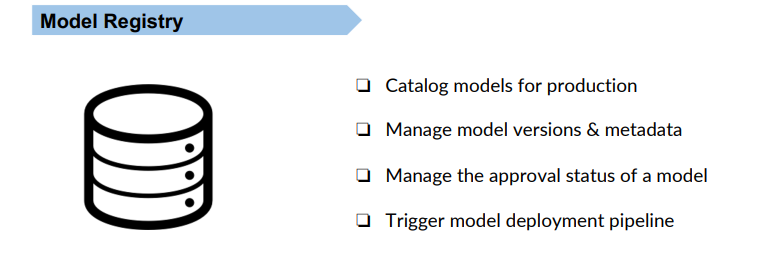

In [26]:
model_package_group_name = 'churn-month1-pipeline'


model_approval_status = ParameterString(
    name="ModelApprovalStatus",
    default_value="PendingManualApproval"
)


deploy_instance_type = ParameterString(
    name="DeployInstanceType",
    default_value="ml.m5.large"
)


deploy_instance_count = ParameterInteger(
    name="DeployInstanceCount",
    default_value=1
)

In [27]:
churn_inference_image_uri = sagemaker.image_uris.retrieve(
    framework='sklearn',
    version=FRAMEWORK_VERSION,
    instance_type=deploy_instance_type,
    image_scope="inference",
    region=region
)

The input argument instance_type of function (sagemaker.image_uris.retrieve) is a pipeline variable (<class 'sagemaker.workflow.parameters.ParameterString'>), which is interpreted in pipeline execution time only. As the function needs to evaluate the argument value in SDK compile time, the default_value of this Parameter object will be used to override it. Please make sure the default_value is valid.


In [28]:
from sagemaker.model_metrics import MetricsSource, ModelMetrics


model_metrics = ModelMetrics(
    model_statistics=MetricsSource(
        s3_uri='{}/evaluation.json'.format(
            evaluation_step.arguments['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']
        ),
        content_type='application/json'
    )
)

model_metrics.model_statistics

Popping out 'ProcessingJobName' from the pipeline definition by default since it will be overridden at pipeline execution time. Please utilize the PipelineDefinitionConfig to persist this field in the pipeline definition if desired.


In [29]:
from sagemaker.workflow.step_collections import RegisterModel


register_step = RegisterModel(
    name='RegisterModel',
    estimator=sklearn_estimator,
    image_uri=churn_inference_image_uri,
    inference_instances=[deploy_instance_type],
    transform_instances=[deploy_instance_type],
    model_data=tuning_step.get_top_model_s3_uri(top_k=0, s3_bucket=bucket),
    # model_data=tuning_step.properties.ModelArtifacts.S3ModelArtifacts,
    model_package_group_name=model_package_group_name,
    model_metrics=model_metrics,
    approval_status=model_approval_status,
    content_types=['text/csv'],
    response_types=['text/csv'],
)

## 5. Create model for model deployment step

In [31]:
import time
from sagemaker.model import Model


timestamp = int(time.time())
model_name = 'churn-month1-{}'.format(timestamp)


model = Model(
    name=model_name,
    entry_point='./src/inference.py',
    image_uri=churn_inference_image_uri,
    model_data=tuning_step.get_top_model_s3_uri(top_k=0, s3_bucket=bucket),
    # model_data=tuning_step.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sess,
    role=role,
)

In [32]:
from sagemaker.inputs import CreateModelInput

model_inputs = CreateModelInput(
    instance_type=deploy_instance_type
)

In [33]:
from sagemaker.workflow.steps import CreateModelStep


create_model_step = CreateModelStep(
    name='CreateModel',
    model=model,
    inputs=model_inputs
)

## 6. Check model accuracy condition step

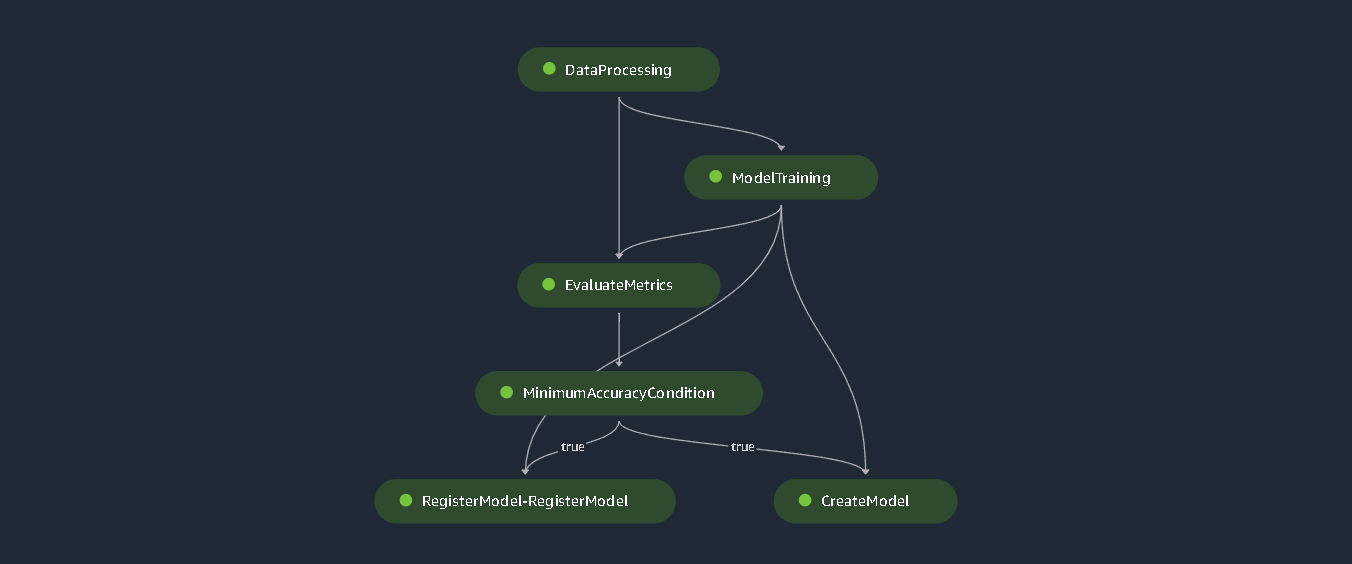

In [34]:
from sagemaker.workflow.conditions import ConditionGreaterThanOrEqualTo
from sagemaker.workflow.functions import JsonGet


minimum_accuracy_value = ParameterFloat(
    name='MinimumAccuracy',
    default_value=0.70
)


minimum_accuracy_condition = ConditionGreaterThanOrEqualTo(
    left=JsonGet(
        step_name=evaluation_step.name,
        step=evaluation_step,
        property_file=evaluation_metrics,
        json_path="metrics.accuracy.value"
    ),
    
    right=minimum_accuracy_value
)

In [35]:
from sagemaker.workflow.condition_step import ConditionStep


condition_step = ConditionStep(
    name='MinimumAccuracyCondition',
    conditions=[minimum_accuracy_condition],
    if_steps=[register_step, create_model_step],
    else_steps = []
)


## 7. Create pipeline
### 7.1 Define pipeline parameters, steps and conditions

In [36]:
timestamp = int(time.time())
pipeline_name = 'churn-month1-pipeline-{}'.format(timestamp)

pipeline_parameters = [
    input_data,
    output_data,
    random_state,
    processing_instance_type,
    processing_instance_count,
    training_instance_type,
    training_instance_count,
    validation_split_percentage,
    test_split_percentage,
    feature_group_name,
    model_approval_status,
    deploy_instance_count,
    deploy_instance_type,
    minimum_accuracy_value
]

In [37]:
from sagemaker.workflow.pipeline import Pipeline 

pipeline = Pipeline(
    name=pipeline_name,
    sagemaker_session=sess,
    parameters=pipeline_parameters,
    steps=[
        processing_step, 
        tuning_step, 
        evaluation_step,
        condition_step
    ]
)

In [38]:
response = pipeline.create(role_arn=role)
pipeline_arn = response.get("PipelineArn")

print(response)

{'PipelineArn': 'arn:aws:sagemaker:eu-west-3:668303144976:pipeline/churn-month1-pipeline-1727875969', 'ResponseMetadata': {'RequestId': 'dcfac1d8-a448-4cd0-a9e4-15c9aae4459a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'dcfac1d8-a448-4cd0-a9e4-15c9aae4459a', 'content-type': 'application/x-amz-json-1.1', 'content-length': '100', 'date': 'Wed, 02 Oct 2024 13:32:50 GMT'}, 'RetryAttempts': 0}}


In [39]:
definition = json.loads(pipeline.definition())

pprint(definition)

{'Metadata': {},
 'Parameters': [{'DefaultValue': '/opt/ml/processing/input/data',
                 'Name': 'input-data',
                 'Type': 'String'},
                {'DefaultValue': '/opt/ml/processing/output',
                 'Name': 'output-data',
                 'Type': 'String'},
                {'DefaultValue': 2024,
                 'Name': 'random-state',
                 'Type': 'Integer'},
                {'DefaultValue': 0.1,
                 'Name': 'validation-split-percentage',
                 'Type': 'Float'},
                {'DefaultValue': 0.2,
                 'Name': 'test-split-percentage',
                 'Type': 'Float'},
                {'DefaultValue': 'bank-churn-mon1-feature-group-{}',
                 'Name': 'feature-group-name',
                 'Type': 'String'},
                {'DefaultValue': 'PendingManualApproval',
                 'Name': 'ModelApprovalStatus',
                 'Type': 'String'},
                {'DefaultValue': 1,
     

### 7.2 Start pipeline

In [41]:
execution = pipeline.start()

### 7.3 Describe pipeline execution

In [61]:
execution_description = execution.describe()
pipeline_execution_arn = execution_description["PipelineExecutionArn"]

print(pipeline_execution_arn)

arn:aws:sagemaker:eu-west-3:668303144976:pipeline/churn-month1-pipeline-1727875969/execution/y8a6c91lumhh


In [62]:
from pprint import pprint

execution_run =  sm.describe_pipeline_execution(PipelineExecutionArn=pipeline_execution_arn)
pprint(execution_run)

{'CreatedBy': {'DomainId': 'd-mqesdqdqrfmi',
               'IamIdentity': {'Arn': 'arn:aws:sts::668303144976:assumed-role/AmazonSageMaker-ExecutionRole-20231108T110667/SageMaker',
                               'PrincipalId': 'AROAZXGPYXAIBBIRXJB33:SageMaker'},
               'UserProfileArn': 'arn:aws:sagemaker:eu-west-3:668303144976:user-profile/d-mqesdqdqrfmi/bedissj-1699438736259',
               'UserProfileName': 'bedissj-1699438736259'},
 'CreationTime': datetime.datetime(2024, 10, 2, 13, 32, 51, 137000, tzinfo=tzlocal()),
 'LastModifiedBy': {'DomainId': 'd-mqesdqdqrfmi',
                    'IamIdentity': {'Arn': 'arn:aws:sts::668303144976:assumed-role/AmazonSageMaker-ExecutionRole-20231108T110667/SageMaker',
                                    'PrincipalId': 'AROAZXGPYXAIBBIRXJB33:SageMaker'},
                    'UserProfileArn': 'arn:aws:sagemaker:eu-west-3:668303144976:user-profile/d-mqesdqdqrfmi/bedissj-1699438736259',
                    'UserProfileName': 'bedissj-16994

### 7.4 Describe completed pipeline
#### 7.4.1 Execution arn and status

In [63]:
pipeline_execution = sm.list_pipeline_executions(PipelineName=pipeline_name)['PipelineExecutionSummaries']
pipeline_execution_status = pipeline_execution[0]["PipelineExecutionStatus"]

while pipeline_execution_status == "Executing":
    pipeline_execution = sm.list_pipeline_executions(PipelineName=pipeline_name)['PipelineExecutionSummaries']
    pipeline_execution_status = pipeline_execution[0]["PipelineExecutionStatus"]

pprint(pipeline_execution)

[{'PipelineExecutionArn': 'arn:aws:sagemaker:eu-west-3:668303144976:pipeline/churn-month1-pipeline-1727875969/execution/y8a6c91lumhh',
  'PipelineExecutionDisplayName': 'execution-1727875971225',
  'PipelineExecutionStatus': 'Succeeded',
  'StartTime': datetime.datetime(2024, 10, 2, 13, 32, 51, 137000, tzinfo=tzlocal())}]


In [64]:
pipeline_execution_arn = pipeline_execution[0]["PipelineExecutionArn"]
print(pipeline_execution_arn)

arn:aws:sagemaker:eu-west-3:668303144976:pipeline/churn-month1-pipeline-1727875969/execution/y8a6c91lumhh


In [65]:
pipeline_execution_status = pipeline_execution[0]["PipelineExecutionStatus"]
print(pipeline_execution_status)


Succeeded


#### 7.4.2 Execution steps

In [66]:
execution_steps = sm.list_pipeline_execution_steps(PipelineExecutionArn=pipeline_execution_arn)["PipelineExecutionSteps"]
pprint(execution_steps)

[{'AttemptCount': 1,
  'EndTime': datetime.datetime(2024, 10, 2, 13, 51, 5, 327000, tzinfo=tzlocal()),
  'Metadata': {'Model': {'Arn': 'arn:aws:sagemaker:eu-west-3:668303144976:model/pipelines-y8a6c91lumhh-CreateModel-eJO6K98Cgh'}},
  'StartTime': datetime.datetime(2024, 10, 2, 13, 51, 3, 756000, tzinfo=tzlocal()),
  'StepName': 'CreateModel',
  'StepStatus': 'Succeeded'},
 {'AttemptCount': 1,
  'EndTime': datetime.datetime(2024, 10, 2, 13, 51, 5, 626000, tzinfo=tzlocal()),
  'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:eu-west-3:668303144976:model-package/churn-month1-pipeline/2'}},
  'StartTime': datetime.datetime(2024, 10, 2, 13, 51, 3, 756000, tzinfo=tzlocal()),
  'StepName': 'RegisterModel-RegisterModel',
  'StepStatus': 'Succeeded'},
 {'AttemptCount': 1,
  'EndTime': datetime.datetime(2024, 10, 2, 13, 51, 3, 284000, tzinfo=tzlocal()),
  'Metadata': {'Condition': {'Outcome': 'True'}},
  'StartTime': datetime.datetime(2024, 10, 2, 13, 51, 2, 784000, tzinfo=tzlocal()),
 

#### 7.4.3 Execution parameters

In [67]:
execution_parameters = sm.list_pipeline_parameters_for_execution(PipelineExecutionArn=pipeline_execution_arn)
pprint(execution_parameters)

{'PipelineParameters': [{'Name': 'input-data',
                         'Value': '/opt/ml/processing/input/data'},
                        {'Name': 'output-data',
                         'Value': '/opt/ml/processing/output'},
                        {'Name': 'feature-group-name',
                         'Value': 'bank-churn-mon1-feature-group-{}'},
                        {'Name': 'validation-split-percentage', 'Value': '0.1'},
                        {'Name': 'DeployInstanceType', 'Value': 'ml.m5.large'},
                        {'Name': 'test-split-percentage', 'Value': '0.2'},
                        {'Name': 'MinimumAccuracy', 'Value': '0.7'},
                        {'Name': 'ModelApprovalStatus',
                         'Value': 'PendingManualApproval'},
                        {'Name': 'random-state', 'Value': '2024'},
                        {'Name': 'DeployInstanceCount', 'Value': '1'}],
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '556',
                        

## 8. Model evaluation

Pull the evaluation report S3 Uri from the evaluation step.

In [68]:
processing_job_name = None

for execution_step in reversed(execution_steps):
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    if execution_step["StepName"] == "EvaluateMetrics": # Replace all None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
        processing_job_name=execution_step['Metadata']['ProcessingJob']['Arn'].split('/')[-1]

describe_evaluation_processing_job_response = sm.describe_processing_job(ProcessingJobName=processing_job_name)

evaluation_metrics_s3_uri = describe_evaluation_processing_job_response['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']
print('Evaluation output: {}'.format(evaluation_metrics_s3_uri))

Evaluation output: s3://sagemaker-eu-west-3-668303144976/EvaluateMetrics-558cc2049391644b997c852ef17938f9/output/metrics


Download the evaluation report and display the metrics.

In [69]:
evaluation_json = sagemaker.s3.S3Downloader.read_file("{}/evaluation.json".format(
    evaluation_metrics_s3_uri
))

pprint(json.loads(evaluation_json))

{'metrics': {'accuracy': {'value': 0.9481481481481482},
             'f1_score': {'value': 0.8223350253807107}}}


Similar approach to pull the processing step artifacts

In [70]:
processing_job_name = None

# pull the processing step name
for execution_step in reversed(execution_steps):
    if execution_step['StepName'] == 'DataProcessing':
        processing_job_name=execution_step['Metadata']['ProcessingJob']['Arn'].split('/')[-1]

# get the description of the processing job
describe_transform_processing_job_response = sm.describe_processing_job(ProcessingJobName=processing_job_name)

# get the output S3 path
transform_output_s3_uri = describe_transform_processing_job_response['ProcessingOutputConfig']['Outputs']
pprint(transform_output_s3_uri)

[{'AppManaged': False,
  'OutputName': 'bank-churn-mon1-train',
  'S3Output': {'LocalPath': '/opt/ml/processing/output/train',
               'S3UploadMode': 'EndOfJob',
               'S3Uri': 's3://sagemaker-eu-west-3-668303144976/DataProcessing-87817bb2d85a0748c95fba8dae5719b4/output/bank-churn-mon1-train'}},
 {'AppManaged': False,
  'OutputName': 'bank-churn-mon1-validation',
  'S3Output': {'LocalPath': '/opt/ml/processing/output/validation',
               'S3UploadMode': 'EndOfJob',
               'S3Uri': 's3://sagemaker-eu-west-3-668303144976/DataProcessing-87817bb2d85a0748c95fba8dae5719b4/output/bank-churn-mon1-validation'}},
 {'AppManaged': False,
  'OutputName': 'bank-churn-mon1-test',
  'S3Output': {'LocalPath': '/opt/ml/processing/output/test',
               'S3UploadMode': 'EndOfJob',
               'S3Uri': 's3://sagemaker-eu-west-3-668303144976/DataProcessing-87817bb2d85a0748c95fba8dae5719b4/output/bank-churn-mon1-test'}},
 {'AppManaged': False,
  'OutputName': 'bank-c

Similar approach can be applied to retrieve training step artifacts

In [71]:
training_job_arn=None

for execution_step in execution_steps:
    ### BEGIN SOLUTION - DO NOT delete this comment for grading purposes
    if execution_step["StepName"] == "ModelTraining": # Replace all None
    ### END SOLUTION - DO NOT delete this comment for grading purposes
        training_job_arn = execution_step['Metadata']['TuningJob']['Arn']      
        pprint(execution_step)
        break
print('Tuning job ARN: {}'.format(training_job_arn))
        
training_job_name = training_job_arn.split('/')[-1]
print('Tuning job Name: {}'.format(training_job_name))

{'AttemptCount': 1,
 'EndTime': datetime.datetime(2024, 10, 2, 13, 45, 50, 776000, tzinfo=tzlocal()),
 'Metadata': {'TuningJob': {'Arn': 'arn:aws:sagemaker:eu-west-3:668303144976:hyper-parameter-tuning-job/y8a6c91lumhh-ModelTra-GTH766MIe3'}},
 'StartTime': datetime.datetime(2024, 10, 2, 13, 38, 25, 914000, tzinfo=tzlocal()),
 'StepName': 'ModelTraining',
 'StepStatus': 'Succeeded'}
Tuning job ARN: arn:aws:sagemaker:eu-west-3:668303144976:hyper-parameter-tuning-job/y8a6c91lumhh-ModelTra-GTH766MIe3
Tuning job Name: y8a6c91lumhh-ModelTra-GTH766MIe3


Visualize pipeline artifacts

In [72]:
import time
from sagemaker.lineage.visualizer import LineageTableVisualizer

viz = LineageTableVisualizer(sagemaker.session.Session())

for execution_step in reversed(execution_steps):
    pprint(execution_step)
    if execution_step['StepName'] == 'DataProcessing':
        processing_job_name=execution_step['Metadata']['ProcessingJob']['Arn'].split('/')[-1]
        print('Processing job name: {}'.format(processing_job_name))
        display(viz.show(processing_job_name=processing_job_name))
    # elif execution_step['StepName'] == 'ModelTraining':
    #     training_job_name=execution_step['Metadata']['TuningJob']['Arn'].split('/')[-1]
    #     print('Training job name: {}'.format(training_job_name))
    #     display(viz.show(training_job_name=training_job_name))
    else:
        display(viz.show(pipeline_execution_step=execution_step))
        time.sleep(5)

{'AttemptCount': 1,
 'EndTime': datetime.datetime(2024, 10, 2, 13, 38, 25, 242000, tzinfo=tzlocal()),
 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:eu-west-3:668303144976:processing-job/pipelines-y8a6c91lumhh-DataProcessing-OFEKODXsCL'}},
 'StartTime': datetime.datetime(2024, 10, 2, 13, 32, 52, 16000, tzinfo=tzlocal()),
 'StepName': 'DataProcessing',
 'StepStatus': 'Succeeded'}
Processing job name: pipelines-y8a6c91lumhh-DataProcessing-OFEKODXsCL


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...95fba8dae5719b4/input/code/processing.py,Input,DataSet,ContributedTo,artifact
1,s3://...3144976/data/transformed_querying/month1,Input,DataSet,ContributedTo,artifact
2,65978...com/sagemaker-scikit-learn:1.0-1-cpu-py3,Input,Image,ContributedTo,artifact
3,s3://...dae5719b4/output/bank-churn-mon1-encoder,Output,DataSet,Produced,artifact
4,s3://...ba8dae5719b4/output/bank-churn-mon1-test,Output,DataSet,Produced,artifact
5,s3://...5719b4/output/bank-churn-mon1-validation,Output,DataSet,Produced,artifact
6,s3://...a8dae5719b4/output/bank-churn-mon1-train,Output,DataSet,Produced,artifact


{'AttemptCount': 1,
 'EndTime': datetime.datetime(2024, 10, 2, 13, 45, 50, 776000, tzinfo=tzlocal()),
 'Metadata': {'TuningJob': {'Arn': 'arn:aws:sagemaker:eu-west-3:668303144976:hyper-parameter-tuning-job/y8a6c91lumhh-ModelTra-GTH766MIe3'}},
 'StartTime': datetime.datetime(2024, 10, 2, 13, 38, 25, 914000, tzinfo=tzlocal()),
 'StepName': 'ModelTraining',
 'StepStatus': 'Succeeded'}


None

{'AttemptCount': 1,
 'EndTime': datetime.datetime(2024, 10, 2, 13, 51, 1, 717000, tzinfo=tzlocal()),
 'Metadata': {'ProcessingJob': {'Arn': 'arn:aws:sagemaker:eu-west-3:668303144976:processing-job/pipelines-y8a6c91lumhh-EvaluateMetrics-YQTHrwwOOr'}},
 'StartTime': datetime.datetime(2024, 10, 2, 13, 45, 51, 225000, tzinfo=tzlocal()),
 'StepName': 'EvaluateMetrics',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...ef17938f9/input/code/evaluate_metrics.py,Input,DataSet,ContributedTo,artifact
1,s3://...ba8dae5719b4/output/bank-churn-mon1-test,Input,DataSet,ContributedTo,artifact
2,s3://...766MIe3-009-d26a0a08/output/model.tar.gz,Input,Model,ContributedTo,artifact
3,65978...com/sagemaker-scikit-learn:1.0-1-cpu-py3,Input,Image,ContributedTo,artifact
4,s3://...49391644b997c852ef17938f9/output/metrics,Output,DataSet,Produced,artifact


{'AttemptCount': 1,
 'EndTime': datetime.datetime(2024, 10, 2, 13, 51, 3, 284000, tzinfo=tzlocal()),
 'Metadata': {'Condition': {'Outcome': 'True'}},
 'StartTime': datetime.datetime(2024, 10, 2, 13, 51, 2, 784000, tzinfo=tzlocal()),
 'StepName': 'MinimumAccuracyCondition',
 'StepStatus': 'Succeeded'}


None

{'AttemptCount': 1,
 'EndTime': datetime.datetime(2024, 10, 2, 13, 51, 5, 626000, tzinfo=tzlocal()),
 'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:eu-west-3:668303144976:model-package/churn-month1-pipeline/2'}},
 'StartTime': datetime.datetime(2024, 10, 2, 13, 51, 3, 756000, tzinfo=tzlocal()),
 'StepName': 'RegisterModel-RegisterModel',
 'StepStatus': 'Succeeded'}


,Name/Source,Direction,Type,Association Type,Lineage Type
0,s3://...766MIe3-009-d26a0a08/output/model.tar.gz,Input,Model,ContributedTo,artifact
1,65978...com/sagemaker-scikit-learn:1.0-1-cpu-py3,Input,Image,ContributedTo,artifact
2,churn-month1-pipeline-2-PendingManualApproval-...,Input,Approval,ContributedTo,action
3,churn-month1-pipeline-1727453981-aws-model-pac...,Output,ModelGroup,AssociatedWith,context


{'AttemptCount': 1,
 'EndTime': datetime.datetime(2024, 10, 2, 13, 51, 5, 327000, tzinfo=tzlocal()),
 'Metadata': {'Model': {'Arn': 'arn:aws:sagemaker:eu-west-3:668303144976:model/pipelines-y8a6c91lumhh-CreateModel-eJO6K98Cgh'}},
 'StartTime': datetime.datetime(2024, 10, 2, 13, 51, 3, 756000, tzinfo=tzlocal()),
 'StepName': 'CreateModel',
 'StepStatus': 'Succeeded'}


None

## 9. Model deployment and testing

### 9.1 Approve trained model

In [73]:
for execution_step in reversed(execution_steps):
    if execution_step["StepName"] == "RegisterModel-RegisterModel":
        model_package_arn = execution_step["Metadata"]["RegisterModel"]["Arn"]
        break
        
print("Model package arn: {}".format(model_package_arn))

Model package arn: arn:aws:sagemaker:eu-west-3:668303144976:model-package/churn-month1-pipeline/2


Update model package to `Approved` status before deployment.

In [74]:
model_package_response = sm.update_model_package(
    ModelPackageArn=model_package_arn,
    ModelApprovalStatus="Approved",
    ApprovalDescription="Accuracy is good, Ok for depoyment."
)

pprint(model_package_response)

{'ModelPackageArn': 'arn:aws:sagemaker:eu-west-3:668303144976:model-package/churn-month1-pipeline/2',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '100',
                                      'content-type': 'application/x-amz-json-1.1',
                                      'date': 'Wed, 02 Oct 2024 14:07:28 GMT',
                                      'x-amzn-requestid': '3f52e10d-7a8a-4214-9a38-cc769e7485a4'},
                      'HTTPStatusCode': 200,
                      'RequestId': '3f52e10d-7a8a-4214-9a38-cc769e7485a4',
                      'RetryAttempts': 0}}


### 9.3 Create endpoint from model registry

#### 9.3.1 Retrieve model name
Model arn and name need to be pulled from the pipeline execution steps.

In [75]:
for execution_step in reversed(execution_steps):
    if execution_step["StepName"] == "CreateModel":
        model_arn = execution_step["Metadata"]["Model"]["Arn"]
        break

model_name = model_arn.split('/')[-1]
print("Model arn: {}".format(model_arn))
print("Model name: {}".format(model_name))

Model arn: arn:aws:sagemaker:eu-west-3:668303144976:model/pipelines-y8a6c91lumhh-CreateModel-eJO6K98Cgh
Model name: pipelines-y8a6c91lumhh-CreateModel-eJO6K98Cgh


#### 9.3.2 Configure and create the endpoint

Create the endpoint configuration.


In [76]:
import time

timestamp = int(time.time())

In [77]:
endpoint_config_name = 'churn-prediction-epc-{}'.format(timestamp)

create_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'InstanceType':'ml.m5.xlarge',
            'InitialVariantWeight':1,
            'InitialInstanceCount':1,
            'ModelName': model_name,
            'VariantName':'AllTraffic'
        }
    ]
)

Create the endpoint

In [78]:
endpoint_name = 'churn-prediction-ep-{}'.format(timestamp)

create_endpoint_response = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)

print(create_endpoint_response['EndpointArn'])

arn:aws:sagemaker:eu-west-3:668303144976:endpoint/churn-prediction-ep-1727878061


Wait until endpoint is deployed.

In [79]:
%%time

while True:
    try: 
        waiter = sm.get_waiter('endpoint_in_service')
        print('Waiting for endpoint to be in `InService`...')
        waiter.wait(EndpointName=endpoint_name)
        break;
    except:
        print('Waiting for endpoint...')
        endpoint_status = sm.describe_endpoint(EndpointName=endpoint_name)['EndpointStatus']
        print('Endpoint status: {}'.format(endpoint_status))
        if endpoint_status == 'Failed':
            break
        time.sleep(30)
        
print('Endpoint deployed.')

Waiting for endpoint to be in `InService`...
Endpoint deployed.
CPU times: user 34.5 ms, sys: 20.8 ms, total: 55.3 ms
Wall time: 3min 30s


### 9.4 Inference testing

In [ ]:
from sagemaker.predictor import Predictor
from sagemaker.base_serializers import CSVSerializer
from sagemaker.base_deserializers import CSVDeserializer


csv_serializer = CSVSerializer()
csv_deserializer = CSVDeserializer()

inputs =pd.read_csv('./inference/BankChurners_mon1 (3).csv')

predictor = Predictor(
    endpoint_name=endpoint_name,
    serializer=csv_serializer,
    deserializer=csv_deserializer,
    sagemaker_session=sess
)

predicted_classes = predictor.predict(inputs)

for predicted_class in predicted_classes:
    print("Predicted class {} with probability {}".format(predicted_class['predicted_label'], predicted_class['probability']))

### 9.5 Cleanup resources

In [95]:
sm.delete_model(ModelName=model_name)
sm.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'df53d029-a106-4de5-92c6-f3d9ad8ee491',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'df53d029-a106-4de5-92c6-f3d9ad8ee491',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Wed, 02 Oct 2024 16:10:32 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}